# The Probability Integral Transform (PIT)

The probability intergral transform (PIT) provides a method for assessing to what extent a forecast system is probabililistically calibrated. 
A forecast system is probabilistically calibrated if random draws from its predictive distributions are statistically indistinguishable from the corresponding observations.

Some blah about the definition of PIT. Some blah about handling discontinuous distributions.

We begin with a simple example that illustrates the `scores` implementation of PIT when the predictive distributions are normal (and hence continuous).

## Case study 1



In [1]:
import numpy as np
import xarray as xr
from scipy.stats import norm
import matplotlib.pyplot as plt

n_cases = 100000
n_member = 100

mu = norm.rvs(loc = 0, scale = 1, size=n_cases)

n_member = 100
mu_broadcast = np.broadcast_to(mu, (n_member, n_cases))



obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_cases),
    dims=['case'],
    coords={'case': range(n_cases)},
    name='obs',
)



fcstA = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstA',
)
fcstB = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast + 0.25, scale = 1, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstB',
)
fcstC = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast - 0.25, scale = 1, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstC',
)
fcstD = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1.2, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstD',
)
fcstE = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1 / 1.2, size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstE',
)
fcstF = xr.DataArray(
    data=norm.rvs(loc = 0, scale = np.sqrt(2), size=(n_member,n_cases)),
    dims=['ens_member', 'case'],
    coords={'ens_member': range(n_member), 'case': range(n_cases)},
    name='fcstF',
)

fcst = xr.merge([fcstA, fcstB, fcstC, fcstD, fcstE, fcstF])

Now we'll calculate PIT

In [2]:
from scores.probability import Pit

pit = Pit(fcst, obs, 'ens_member', fcst_type='ensemble', reduce_dims='all')


In [3]:
n_bins = 20
hist_values = pit.hist_values(n_bins, right = True)
hist_values

<xarray.Dataset> Size: 1kB
Dimensions:             (bin_centre: 20)
Coordinates:
  * bin_centre          (bin_centre) float64 160B 0.025 0.075 ... 0.925 0.975
    bin_left_endpoint   (bin_centre) float64 160B 0.0 0.05 0.1 ... 0.85 0.9 0.95
    bin_right_endpoint  (bin_centre) float64 160B 0.05 0.1 0.15 ... 0.9 0.95 1.0
Data variables:
    fcstA               (bin_centre) float64 160B 0.05908 0.04941 ... 0.04964
    fcstB               (bin_centre) float64 160B 0.09454 0.06778 ... 0.02872
    fcstC               (bin_centre) float64 160B 0.03507 0.0345 ... 0.07981
    fcstD               (bin_centre) float64 160B 0.03154 0.03916 ... 0.0251
    fcstE               (bin_centre) float64 160B 0.09453 0.05704 ... 0.08301
    fcstF               (bin_centre) float64 160B 0.05838 0.04861 ... 0.05004

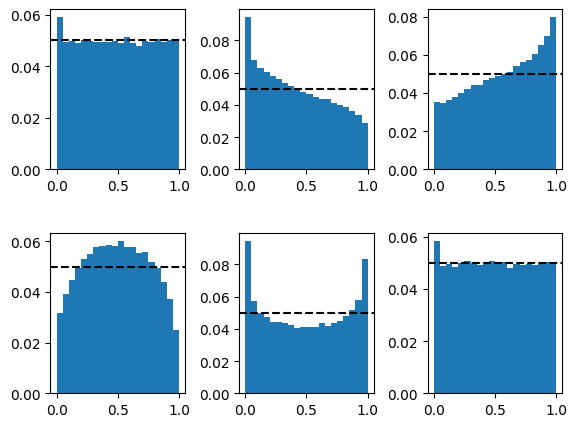

In [4]:


fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].bar(hist_values['bin_centre'].values, hist_values[fcst_label].values, width=1/n_bins)
    axes[int(i / 3), i % 3].axhline(y=1/n_bins, color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

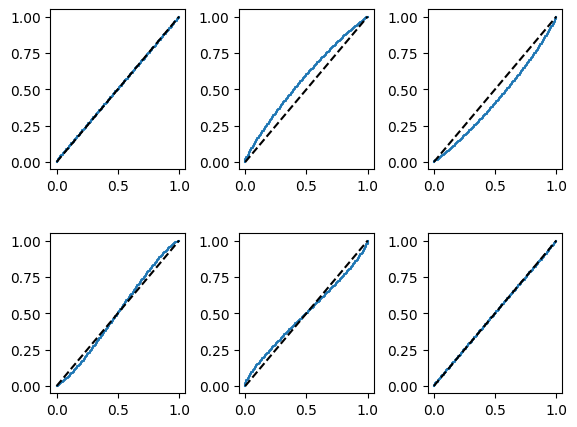

In [5]:
ppoints = pit.plotting_points()

fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].plot(ppoints['pit_x_value'].values, ppoints[fcst_label].values)
    axes[int(i / 3), i % 3].plot([0, 1], [0, 1], color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

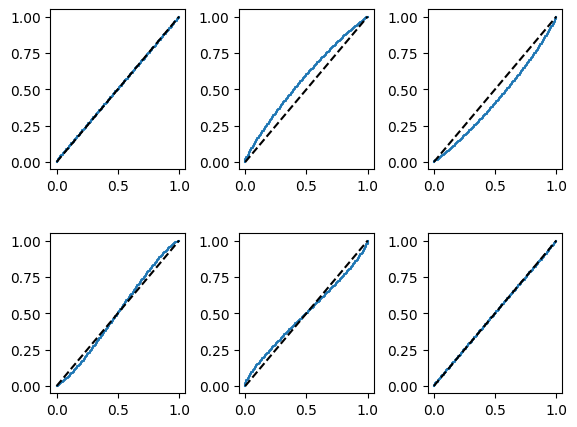

In [6]:
pppoint = pit.plotting_points_parametric()

fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].plot(pppoint['x_plotting_position'][fcst_label].values, pppoint['y_plotting_position'][fcst_label].values)
    axes[int(i / 3), i % 3].plot([0, 1], [0, 1], color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

In [7]:
pit.alpha_score()

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    fcstA    float64 8B 0.005003
    fcstB    float64 8B 0.07022
    fcstC    float64 8B 0.07025
    fcstD    float64 8B 0.02604
    fcstE    float64 8B 0.03137
    fcstF    float64 8B 0.005029

In [12]:
pit_exp = pit.expected_value()
pit_var = pit.variance()
variables = list(pit_exp.data_vars)
exp_values = [float(pit_exp[variable] - 1/2) for variable in variables]
var_values = [float(pit_var[variable] - 1/12) for variable in variables]
var_values

[0.0017271295937766745,
 -0.0003010536069733144,
 -0.0003716184520932836,
 -0.014306353669333374,
 0.01873080262337666,
 0.0014809464349766904]

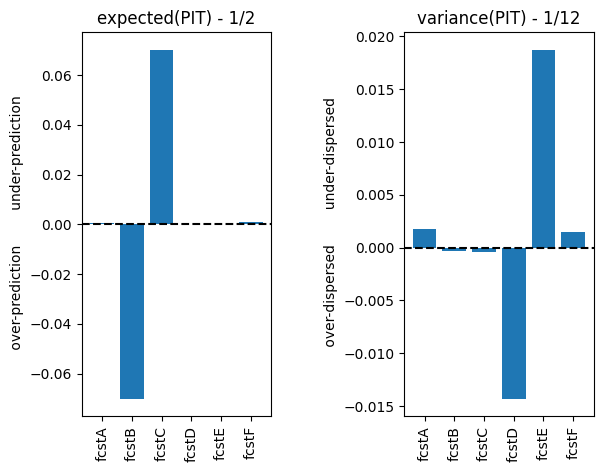

In [14]:
pit_exp = pit.expected_value()
pit_var = pit.variance()
variables = list(pit_exp.data_vars)
exp_values = [float(pit_exp[variable] - 1/2) for variable in variables]
var_values = [float(pit_var[variable] - 1/12) for variable in variables]

fig, axes = plt.subplots(1, 2)

axes[0].axhline(y=0, color='k', linestyle='--')
axes[1].axhline(y=0, color='k', linestyle='--')

axes[0].set_ylabel(' over-prediction        under-prediction')
axes[1].set_ylabel(' over-dispersed        under-dispersed')


axes[0].bar(variables, exp_values)
axes[1].bar(variables, var_values)

axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)

axes[0].set_title('expected(PIT) - 1/2')
axes[1].set_title('variance(PIT) - 1/12')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=.7, hspace=0.4)

fig.show()

In [15]:
fcst_clipped = fcst.clip(min=0, max=2)
obs_clipped = obs.clip(min=0, max=2)
pit_clipped = Pit(fcst_clipped, obs_clipped, 'ens_member', fcst_type='ensemble', reduce_dims='all')

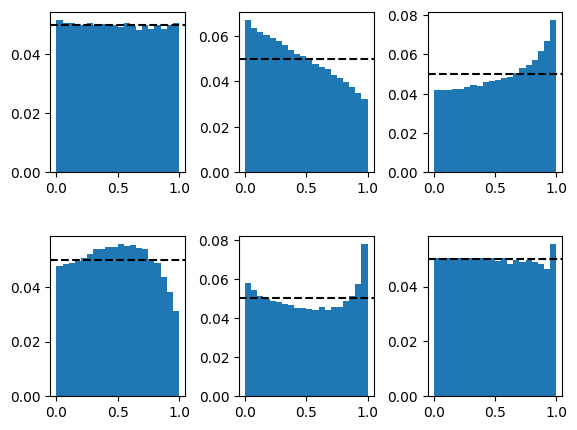

In [16]:
n_bins = 20
hist_values_clipped = pit_clipped.hist_values(n_bins, right = True)

fig, axes = plt.subplots(2, 3)

for fcst_label, i in zip(list(hist_values.data_vars), range(6)):
    axes[int(i / 3), i % 3].bar(hist_values_clipped['bin_centre'].values, hist_values_clipped[fcst_label].values, width=1/n_bins)
    axes[int(i / 3), i % 3].axhline(y=1/n_bins, color='k', linestyle='--')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

fig.show()

## PIT for CDFs

In [19]:
n_cases = 1000
n_x = 100
x_values = np.linspace(-5, 5, n_x)

mu = norm.rvs(loc = 0, scale = 1, size=n_cases)

obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_cases),
    dims=['case'],
    coords={'case': range(n_cases)},
    name='obs',
)



da_mu = xr.DataArray(data=mu, dims=['case'], coords={'case': range(n_cases)})
da_x = xr.DataArray(data=x_values, dims=['x'], coords={'x': x_values})
da_mu, da_x = xr.broadcast(da_mu, da_x)

cdfA = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu, scale = 1),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfA',
)
cdfB = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu + 0.25, scale = 1),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfB',
)
cdfC = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu - 0.25, scale = 1),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfC',
)
cdfD = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu, scale = 1.2),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfD',
)
cdfE = xr.DataArray(
    data=norm.cdf(da_x, loc = da_mu, scale = 1 / 1.2),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfE',
)
cdfF = xr.DataArray(
    data=norm.cdf(da_x, loc = 0, scale = np.sqrt(2)),
    dims=['case', 'x'],
    coords={'x': x_values, 'case': range(n_cases)},
    name='cdfF',
)
cdf = xr.merge([cdfA, cdfB, cdfC, cdfD, cdfE, cdfF])
cdf


<xarray.Dataset> Size: 5MB
Dimensions:  (x: 100, case: 1000)
Coordinates:
  * x        (x) float64 800B -5.0 -4.899 -4.798 -4.697 ... 4.798 4.899 5.0
  * case     (case) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    cdfA     (case, x) float64 800kB 8.434e-06 1.324e-05 2.059e-05 ... 1.0 1.0
    cdfB     (case, x) float64 800kB 2.647e-06 4.258e-06 6.784e-06 ... 1.0 1.0
    cdfC     (case, x) float64 800kB 2.531e-05 3.879e-05 5.888e-05 ... 1.0 1.0
    cdfD     (case, x) float64 800kB 0.0001681 0.0002314 0.0003162 ... 1.0 1.0
    cdfE     (case, x) float64 800kB 1.213e-07 2.302e-07 4.307e-07 ... 1.0 1.0
    cdfF     (case, x) float64 800kB 0.0002035 0.000266 ... 0.9997 0.9998

In [20]:
obs

<xarray.DataArray 'obs' (case: 1000)> Size: 8kB
array([-4.49632128e-01,  7.33796863e-01,  3.67830162e+00,  5.92935754e-01,
        6.87721665e-01,  1.82871357e+00, -3.38051051e+00,  9.23699734e-01,
       -2.44914641e-01,  1.93549192e-01, -1.82501877e-01,  7.03768403e-01,
        9.09681805e-01, -3.99899572e-01,  6.65363975e-01, -1.63190008e+00,
       -1.26735908e+00,  2.73592278e-01, -5.48921103e-01,  1.36789918e+00,
       -3.86727423e+00, -1.70148364e+00, -5.42574733e-01, -1.01066810e+00,
        1.08704002e+00, -2.62663017e-02,  5.88179233e-01,  6.01327561e-01,
        1.68728994e+00,  1.59424028e-01,  1.49324258e+00,  6.85363744e-01,
        9.64860832e-01, -1.20289581e+00, -8.75808688e-01,  2.74513071e-01,
        2.53429176e+00, -6.43884751e-01, -5.51683785e-01,  1.02177616e+00,
        2.15360967e+00, -3.17841208e+00, -1.61289088e+00,  4.54511905e-01,
       -1.96133631e+00, -8.22059483e-01, -7.16001968e-01, -2.13171129e+00,
       -5.94331849e-01, -1.01459563e+00, -3.12121075e+00,  1.19423181e+00,
       -1.16543138e+00, -1.58075575e+00,  1.26360530e-01,  1.00007141e+00,
        1.32152513e+00,  3.46761776e+00, -2.69260781e-01, -1.97639076e+00,
        1.84320172e+00, -2.45716559e-01, -5.81285816e-01, -5.20319172e-01,
       -1.66365064e+00,  1.18484375e+00,  2.20306011e+00, -1.19327448e+00,
       -1.18252364e+00,  1.01775090e+00,  1.34452605e+00, -1.65539164e+00,
       -1.47754690e+00,  5.61412251e-01, -6.93378659e-01,  3.48276425e-01,
       -1.15301524e+00, -1.68846922e+00, -1.08549069e+00, -1.47755305e+00,
...
       -9.61273638e-01, -2.38345575e+00, -1.24028751e-01,  6.33115713e-01,
        1.46993757e+00,  1.43379902e-01,  2.86612527e-01,  5.54728920e-01,
       -2.22171094e+00, -1.17388126e+00, -2.27417315e-01, -3.99045404e-01,
        3.89813510e-01, -1.01675042e+00, -3.43920070e+00, -9.74803438e-01,
       -2.28677510e-01,  9.78043358e-01,  1.74499695e+00,  1.64855118e+00,
       -1.58693902e-01, -2.13318739e+00,  5.74677105e-01, -1.15804722e+00,
       -2.11832482e+00, -5.65947842e-01,  5.49472370e-01, -1.38233701e+00,
       -3.48825644e+00,  6.19381870e-01,  8.94639272e-01,  2.79689792e+00,
       -1.47702493e+00, -4.71590672e-01,  2.73635680e+00,  1.27601826e+00,
        3.04621208e-01,  2.38276289e+00, -1.92752049e-01, -4.77977556e-01,
        9.35188527e-01,  5.58679641e-01, -4.11912906e-01,  4.51811335e-01,
       -6.38542146e-01,  3.50975655e-02, -4.10955337e-01,  2.05213196e+00,
       -6.53383869e-01,  1.17243211e+00, -1.52949105e+00, -1.49012475e+00,
        1.96867276e-01, -5.20440935e-01, -9.82550411e-01,  1.12888567e+00,
       -8.32838604e-01,  3.70895422e-01, -1.14626188e+00,  2.26293649e-01,
       -8.72100724e-01,  1.21085595e+00, -5.66237721e-01,  1.38869966e+00,
       -1.15943152e+00,  9.47346914e-01, -2.23972391e+00,  8.43849688e-01,
       -8.27298260e-01,  3.77755021e+00,  3.65409308e-01, -2.24727008e-01,
        1.27895335e+00,  1.48397367e+00, -3.05455562e+00, -7.47494573e-01,
        5.09322083e-02,  1.73075122e-01, -1.69077203e+00,  9.63529971e-01])
Coordinates:
  * case     (case) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [18]:
pit_cdf = Pit(cdf, obs, 'x', fcst_type='cdf', reduce_dims='all')

ValueError: unable to convert unnamed DataArray to a Dataset without providing an explicit name